# Proyecto 4; Carrera de Data Science en Acámica. 

## Juan Miguel Salazar Muñoz

## Introducción

En el siguiente notebook se buscará desarrollar un mejor modelo predictivo que el logrado en el proyecto 3 para los pasos de automóviles de manera semanal, con pago en efectivo, en la estación Illía de Buenos Aires, Argentina, y con ello lograr predicciones más cercanas a la realidad. 

En el proyecto 3, el modelo que menor error arrojaba en la etapa de test fue el Regresor de Random Forest, con una profundidad de 15 y n_estimadores de 250. Dicho modelo obtuvo un RMSE de 10,300.

Se tiene acceso a dicho proyecto a través del siguiente enlace: https://github.com/JuanMiguel0910/Proyecto3Acamica

Para el presente proyecto, se buscará la implementación de los modelos ARIMA y Prophet. Dichos modelos son elegidos debido a que en la comunidad son reconocidos como ser muy buenos para predicciones con series de tiempo y que al momento, son desconocidos por el desarrollador de este notebook. 



#### Importando las librerías que utilizaremos para el Proyecto.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet

#### Importando el dataset que fue utilizado en el Proyecto 3 para utilizarlo en este proyecto. 

In [3]:
dataset = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Proyecto_4/Datasetsemanal.csv', sep =',')

In [4]:
dataset= dataset.set_index('fecha2')
dataset['index'] = dataset.index

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha'] = pd.to_datetime(dataset.index)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['index'], inplace = True)

#Resampleamos nuestros datos para agrupar por fecha
dataset = dataset.set_index('fecha')

In [5]:
dataset.head()

,cantidad_pasos
fecha,
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0
2017-02-05,359401.0


## 1. Análisis de Datos

A continuación, se realizará un análisis de datos para observar la tendencia, estacionalidad y residuos que son generados por el dataset. 

#### Tendencia, estacionalidad y residuos semanales presentes en el dataset

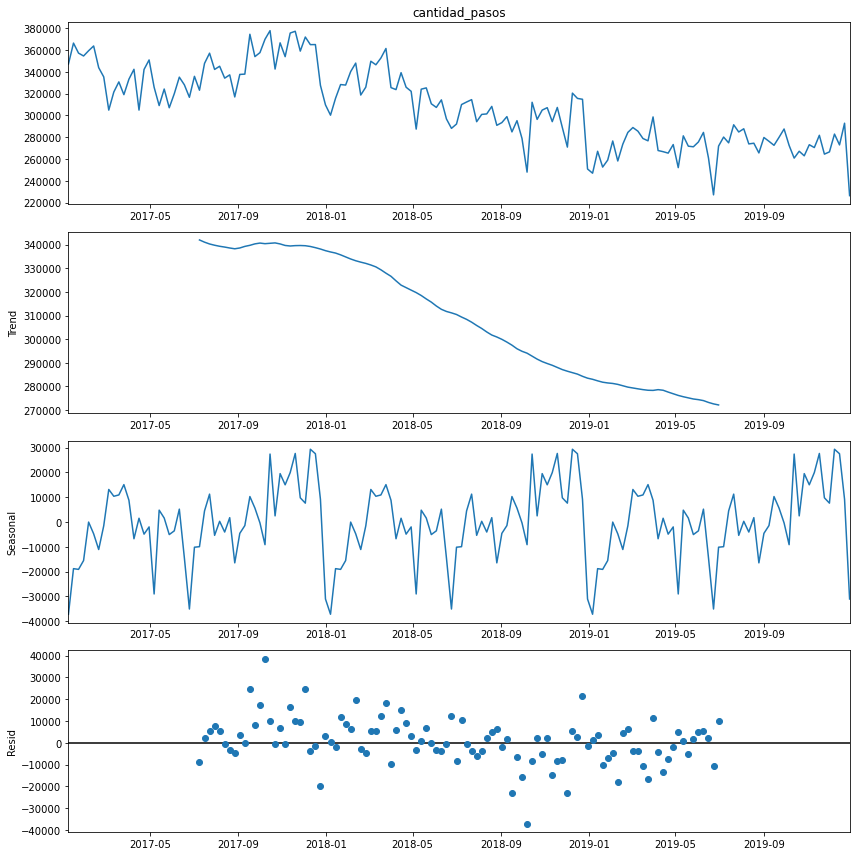

In [7]:
result = seasonal_decompose(dataset.cantidad_pasos, model='additive')
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

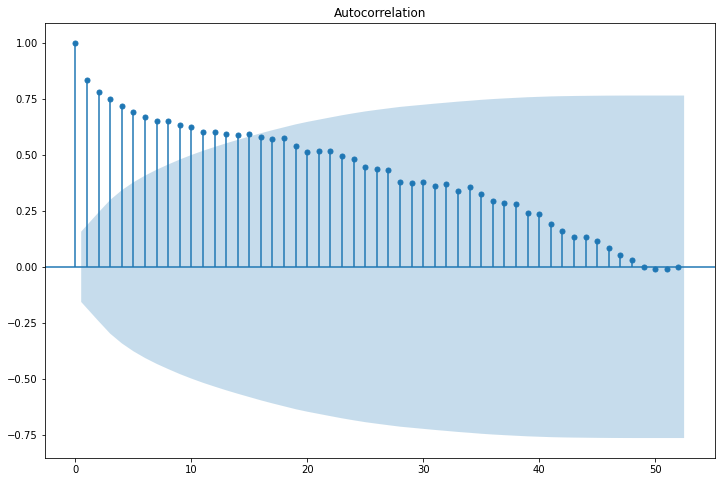

In [12]:
matplotlib.rcParams['figure.figsize'] = [12,8]
plot_acf(dataset.cantidad_pasos, lags = 52)
plt.show()

### Conclusiones


Se puede observar la tendencia a la baja del tráfico en la estación Illia con método de pago de efectivo con el gráfico de trend. 


Con el gráfico de estacionalidad, se puede determinar el decremento de tráfico en los meses febrero, marzo y abril. Un aumento entre abril y mayo, posiblemente atribuible a las vacaciones de semana santa, y un aumento en los meses finales del año, que pueden ser atribuibles a las vacaciones decembrinas. 


El gráfico de residuos no presenta comportamiento alguno, se presentan los puntos de manera aleatoria. Esto nos indica que los datos vienen presentados en una buena granularidad, apropiada para realizar sobre de ellos modelos predictivos. 

Por último, el gráfico de autocorrelación, a medida que pasa el tiempo se va perdiendo la capacidad predictoria de los datos, llegando hasta la instancia 16 con cierto grado de confianza.

## 2. Preparando X e Y. 

### Definiendo X, y, y los valores de train y test.

In [6]:
senial = dataset.cantidad_pasos
look_back = 16 #Utilizo 16 semanas para predecir 1

In [7]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1) 
print(X.shape, y.shape)

(139, 16) (139,)


In [8]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back] 
    y[i] = senial.iloc[i+look_back] 

In [9]:
N_train = 127 # cantidad de instancias que vamos a usar para entrenar. 
N_test = 12 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print("Train", X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print("Test", X_test.shape, y_test.shape)

Train (127, 16) (127,)
Test (12, 16) (12,)


# 3. Ejecución de modelos

En la siguiente sección, se desarrollaran 3 modelos de predicción. Se mostrará el desempeño del modelo de Random Forest como benchmark, y se desarrollarán los modelos ARIMA y Prophet. 

## 3.1. Modelo benchmark; Random Forest

In [10]:
# Creación del modelo
rf = RandomForestRegressor(max_depth = 15, n_estimators = 250).fit(X_train,y_train)

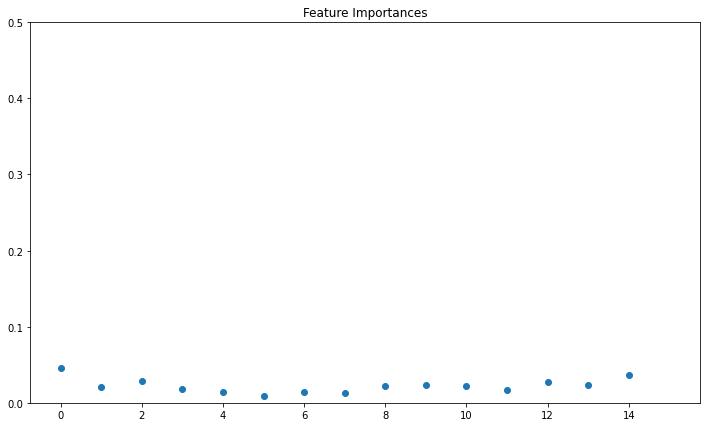

In [11]:
#Viendo la importancia que le da a las features que utiliza para predecri.
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.title("Feature Importances")
plt.ylim([0,.5])
plt.show()

Podemos observar que el modelo le da mayor peso al dato más reciente, al de hace 10 semanas y de 14 semanas. 

In [12]:
#Realizando las predicciones
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

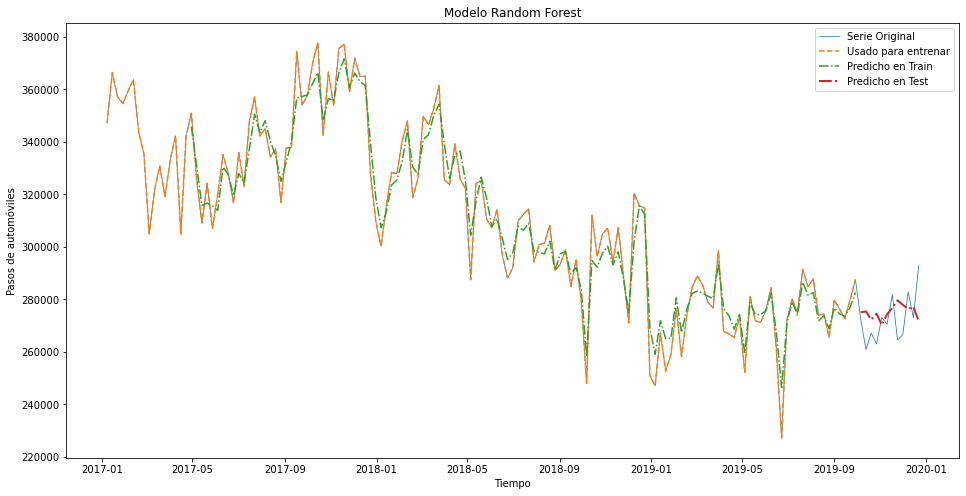

In [13]:
#Gráfico para visualizar las predicciones hechas por el modelo vs datos reales. 
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.title('Modelo Random Forest')
plt.show()

El modelo se muestra en los datos de train, un poco desfazado frente a los datos reales. Por otro lado, en la sección de test, los valores predichos del modelo de cierta forma replican los valore reales de las últimas 16 semanas. No fue capaz de predecir las caídas y subidas que se presentaron a finales del año 2019. 

In [14]:
MSE_train = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE_train))

MSE_test = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE_test))

Error en Train: 6780.632680487791
Error en Test: 10377.313156582351


## 3.2. Modelo Arima

### Prediccion con granularidad semanal

In [15]:
#Definimos "y" que será usada por el modelo para realizar las predicciones de manera semanal. 
y = dataset['cantidad_pasos'].resample('W').mean()
y['2019':]

fecha
2019-01-06    246994.0
2019-01-13    267123.0
2019-01-20    252617.0
2019-01-27    259019.0
2019-02-03    276568.0
2019-02-10    258204.0
2019-02-17    273664.0
2019-02-24    284439.0
2019-03-03    288919.0
2019-03-10    285547.0
2019-03-17    278834.0
2019-03-24    276714.0
2019-03-31    298638.0
2019-04-07    267797.0
2019-04-14    266745.0
2019-04-21    265423.0
2019-04-28    273282.0
2019-05-05    252104.0
2019-05-12    281283.0
2019-05-19    271796.0
2019-05-26    271232.0
2019-06-02    275654.5
2019-06-09    284432.0
2019-06-16    260940.0
2019-06-23    227123.0
2019-06-30    271865.0
2019-07-07    280160.0
2019-07-14    274852.0
2019-07-21    291431.0
2019-07-28    284822.0
2019-08-04    287773.0
2019-08-11    273867.0
2019-08-18    274513.0
2019-08-25    265594.0
2019-09-01    279775.0
2019-09-08    276271.0
2019-09-15    272592.0
2019-09-22    279927.0
2019-09-29    287568.0
2019-10-06    272483.0
2019-10-13    260840.0
2019-10-20    267147.0
2019-10-27    262950.0
2019-

In [8]:
# Definimos diversos parámetros para poder realizar un Grid Search manual para los valores de p, q y d. 
p = q = range(0, 2)
d = range(0,1)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 2, 52)
SARIMAX: (0, 0, 2) x (0, 1, 0, 52)
SARIMAX: (0, 0, 2) x (0, 1, 1, 52)


In [ ]:
#Ejecución del Grid Search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic, ))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:4361.414199306956


/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - AIC:4699.082849431332
ARIMA(0, 0, 0)x(0, 0, 2, 52)12 - AIC:1175.067833600587
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:2513.769919731892
ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - AIC:1203.7637490744935
ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:2424.4874891264603
ARIMA(0, 0, 0)x(1, 0, 1, 52)12 - AIC:2412.7705941768045
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - AIC:1182.9107451587995
ARIMA(0, 0, 0)x(1, 1, 2, 52)12 - AIC:8.0


Una vez ejecutado el Grid Search se elige tomar los siguientes valores para order y seasonal order. 

Dichos valores fueron los elegidos pues se encontraron en un rango medio de valor AIC. 

In [79]:
#Ejecutando el modelo con los valores seleccionados 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1,20),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2055      0.348      0.590      0.555      -0.477       0.888
ma.L1         -0.5657      0.263     -2.149      0.032      -1.082      -0.050
ar.S.L20      -0.4327      0.217     -1.997      0.046      -0.857      -0.008
ma.S.L20      -0.2998      0.152     -1.973      0.049      -0.598      -0.002
sigma2      6.674e+08    2.3e-10    2.9e+18      0.000    6.67e+08    6.67e+08


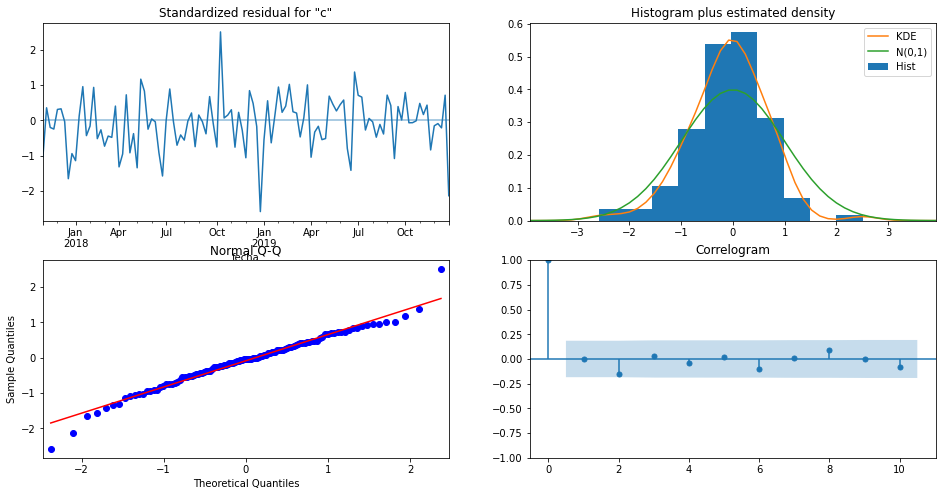

In [80]:
#Graficando diversas métricas obtenidas a partir del modelo.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Como puntos a destacar de los resultados obtenidos por el modelo, se aprecia que los residuos de "c" no presentan tendencia alguna, por lo que el data set es bueno para ser usado en predicciones de series de tiempo. 

El histograma nos revela una distribución normal por parte de los datos, y el correlograma nos indica que el valor más apropiado para realizar la predicción es el más reciente del dataset. 

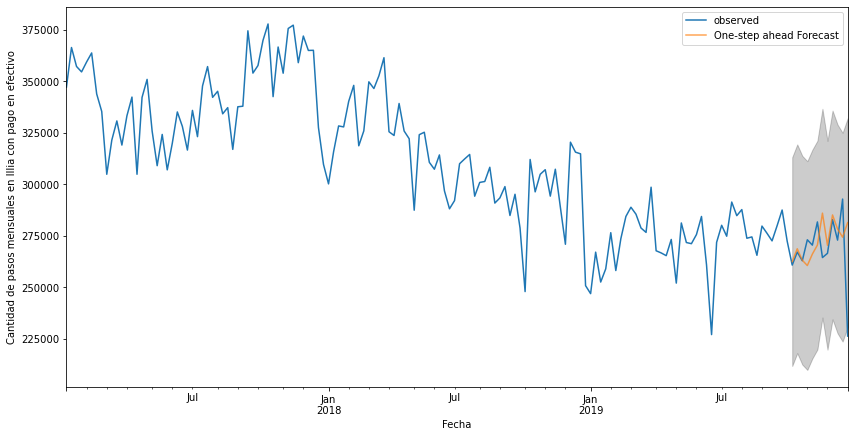

In [81]:
#Graficando los valores reales vs los valores predichos por le modelo ARIMA. 
pred = results.get_prediction(start=pd.to_datetime('2019-10-13'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de pasos mensuales en Illia con pago en efectivo')
plt.legend()

plt.show()

In [82]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-10-13':]

# Calcular el mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('El Mean Squared Error de nuestra predicción es {}'.format(round(mse, 2)))

El Mean Squared Error de nuestra predicción es 349564680.65


In [83]:
print('El Root Mean Squared Error de nuestra predicción es {}'.format(round(np.sqrt(mse), 2)))

El Root Mean Squared Error de nuestra predicción es 18696.65


In [17]:
18696 / 10377 -1 

0.8016767851980342

### Conclusiones

El modelo muestra dificultad para poder predecir los últimos 3 meses del año 2019. Muestra un error en test 80% mayor que el que se obtuvo con el modelo benchmark, por lo cuál se descarta el modelo ARIMA como un modelo bueno para la predicción que queremos realizar. 

De acuerdo con el artículo "ARIMA simplified." de la página Towards Data Science (https://towardsdatascience.com/arima-simplified-b63315f27cbc) para que el modelo pueda tener un mejor rendimiento, se debe trabajar con datos que no presenten estacionalidad. Esto se debe a que el modelo funciona correctamente con datos que son estacionarios.  Para ello, los datos deben de presentar un promedio constante, al igual que la desviación estándard y que no haya estacionalidad en los datos.  

Dicho lo anterior, se puede explicar el mal funcionamiento del modelo ARIMA en gran medida a que en los datos que utilizamos sí existe un grado de estacionalidad. Los pases aumentan para las vacaciones de verano y de diciembre, así como la reducción de ellos en enero y finales de junio. 

## 3.3. Prophet

Ajustamos el dataframe de tal manera que prophet lo pueda interpretar.

In [18]:
dataset_prophet = dataset.rename(columns={'index': 'ds', 'cantidad_pasos': 'y'})
dataset_prophet['ds'] = dataset_prophet.index
dataset_prophet

,y,ds
fecha,,
2017-01-08,347212.0,2017-01-08
2017-01-15,366413.0,2017-01-15
2017-01-22,357215.0,2017-01-22
2017-01-29,354581.0,2017-01-29
2017-02-05,359401.0,2017-02-05
...,...,...
2019-12-01,266555.0,2019-12-01
2019-12-08,282891.0,2019-12-08
2019-12-15,272960.0,2019-12-15


Creamos el modelo a utilizar.

In [19]:
modelo_prophet = Prophet(yearly_seasonality=True,interval_width=0.95)
modelo_prophet.fit(dataset_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Realizamos las predicciones. En este caso le pedimos que prediga 52 semanas. (1 año)

In [20]:
prophet_forecast = modelo_prophet.make_future_dataframe(periods=52, freq='W')
prophet_forecast = modelo_prophet.predict(prophet_forecast)

In [22]:
prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-08,347441.216397,293825.171645,350061.732052,347441.216397,347441.216397,-24394.847874,-24394.847874,-24394.847874,-24394.847874,-24394.847874,-24394.847874,0.0,0.0,0.0,323046.368523
1,2017-01-15,347239.074964,298775.289223,359404.722868,347239.074964,347239.074964,-17002.482784,-17002.482784,-17002.482784,-17002.482784,-17002.482784,-17002.482784,0.0,0.0,0.0,330236.592180
2,2017-01-22,347036.933531,313862.326882,371224.002996,347036.933531,347036.933531,-5195.972788,-5195.972788,-5195.972788,-5195.972788,-5195.972788,-5195.972788,0.0,0.0,0.0,341840.960744
3,2017-01-29,346834.792099,322307.590489,378314.426924,346834.792099,346834.792099,2225.251658,2225.251658,2225.251658,2225.251658,2225.251658,2225.251658,0.0,0.0,0.0,349060.043757
4,2017-02-05,346632.650666,318658.174231,380117.227452,346632.650666,346632.650666,2537.844007,2537.844007,2537.844007,2537.844007,2537.844007,2537.844007,0.0,0.0,0.0,349170.494673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2020-11-29,232413.942864,216452.015420,278282.035927,219229.071631,246235.464878,16199.652603,16199.652603,16199.652603,16199.652603,16199.652603,16199.652603,0.0,0.0,0.0,248613.595466
204,2020-12-06,231884.369182,225762.633049,288002.625351,218201.310266,246257.237265,24227.827641,24227.827641,24227.827641,24227.827641,24227.827641,24227.827641,0.0,0.0,0.0,256112.196823
205,2020-12-13,231354.795501,223540.479367,287554.261741,217141.659708,245972.873060,24687.064573,24687.064573,24687.064573,24687.064573,24687.064573,24687.064573,0.0,0.0,0.0,256041.860074
206,2020-12-20,230825.221820,209993.495996,275165.913105,216081.775852,246116.168669,12110.703482,12110.703482,12110.703482,12110.703482,12110.703482,12110.703482,0.0,0.0,0.0,242935.925302


Graficamos las predicciones del modelo.

<Figure size 1296x576 with 0 Axes>

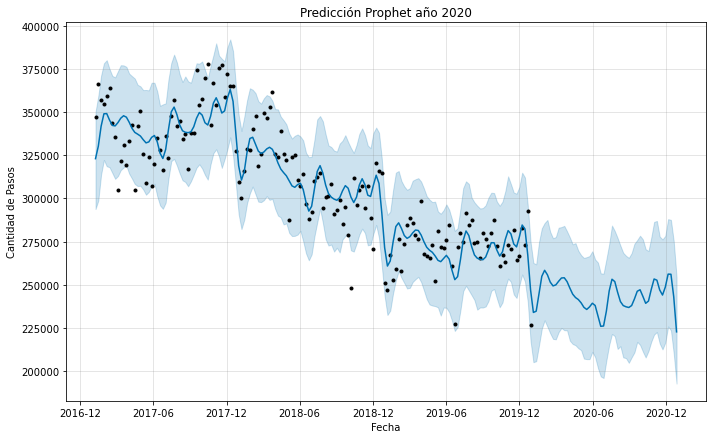

In [21]:
plt.figure(figsize=(18, 8))
modelo_prophet.plot(prophet_forecast, xlabel = 'Fecha', ylabel = 'Cantidad de Pasos')
plt.title('Predicción Prophet año 2020');

Podemos observar como Prophet fue capaz de detectar la tendencia general a la baja de pasos de automóviles en la estación Illia con pago en efectivo que se da año con año en el intervalo de tiempo analizado. 


También podemos ver como logra detectar el incremento de tráfico que se da en los meses de julio y diciembre, al igual que logra predecir la baja de tráfico que se da en el mes de junio y enero. 

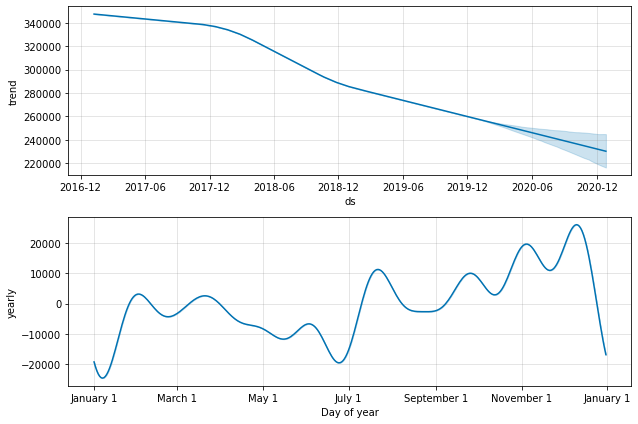

In [180]:
modelo_prophet.plot_components(prophet_forecast);

Observando el gráfico de tendencia podemos observar la tendencia a la baja de los pasos de automóviles en la estación Illía que pagan con efectivo. 

De igual manera, podemos ver que el mes de enero y principios de julio son los meses que menor tráfico se presenta. Los meses que registran más pases de autos son diciembre y julio. 

Calculamos el error del modelo para el último trimestre del año 2019.

In [23]:
# calculate MAE between expected and predicted values for 
y_true = dataset_prophet['y'][-12:].values
y_pred = prophet_forecast['yhat'][-12:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 22700.307


In [24]:
print('El Root Mean Squared Error de nuestra predicción en Prophet es {}'.format(round(np.sqrt(mae), 2)))

El Root Mean Squared Error de nuestra predicción en Prophet es 150.67


Una vez calculado el error, podemos concluir que de los 3 modelos analizados, Prophet es el que mejor desempeño presenta al mostrar un menor error en Test. 

Link para graficar real vs predicho en Profet. 
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

## Predicción vs Valores Reales

A continuación se realizará un gráfico de los valores reales en el año 2020 vs los valores predichos por prophet.

### Preparando datos predichos por Prophet

In [74]:
# Seleccionamos las últimas 52 semanas del dataset creado por prophet, pues son las 52 semanas que corresponden al año 2020. 
prophet_2020 = prophet_forecast
prophet_2020 = prophet_2020.drop(labels=range(0, 156), axis=0)

In [75]:
#Elegimos quedarnos con las columnas ds y yhat, pues contienen la fecha y el valor de la predicción media. 
prophet_2020 = prophet_2020[['ds','yhat']]
prophet_2020.reset_index(drop=True, inplace = True)

In [55]:
#Elegimos quedarnos con las columnas ds y yhat, pues contienen la fecha y el valor de la predicción media. 
prophet_2020 = prophet_2020[['yhat']]

### Importando datos 2020

In [76]:
data2020 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2020.csv', sep =',')

In [77]:
mask = np.logical_and(data2020.estacion=='ILLIA', data2020.forma_pago == 'Efectivo')
data2020 = data2020[mask]

In [78]:
data2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data2020['fecha2'] = pd.to_datetime(data2020.fecha) + pd.to_timedelta(data2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data2020.drop(columns=['fecha','hora_fin'], inplace = True)
data2020.drop(columns = ['mes','dia','dia_fecha', 'tipo_vehiculo','observacion','sentido'], inplace = True)

In [79]:
data2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [80]:
#Reordenamos el dataset por fecha
data2020.sort_values('fecha', inplace = True)
data2020.reset_index(drop=True, inplace = True)
data2020.head()

,cantidad_pasos,fecha
0,7.0,2020-01-01
1,423.0,2020-01-01
2,467.0,2020-01-01
3,6.0,2020-01-01
4,1.0,2020-01-01


In [81]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal2020 = data2020.resample('W', on = 'fecha').sum()
semanal2020.reset_index(drop=True, inplace = True)
print(semanal2020.shape)

(53, 1)


### Unimos dataset Prophet y Valores reales

In [82]:
final = pd.concat([prophet_2020, semanal2020], axis=1)

In [87]:
final = final.set_index('ds')
final.head()

KeyError: "None of ['ds'] are in the columns"

In [90]:
final = final.rename(columns = {'yhat': 'Prophet', 'cantidad_pasos': 'Reales'}, inplace = False)

In [91]:
final.head()

,Prophet,Reales
ds,,
2020-01-05,233899.683664,150623.0
2020-01-12,234615.444464,243359.0
2020-01-19,244799.546572,246818.0
2020-01-26,254850.865795,241192.0
2020-02-02,258336.966167,253335.0


### Gráfica Valores Reales vs Valores Predichos por Prophet

A continuación se realiza la gráfica en donde se muestran los valores predichos por el modelo Prophet vs los valores reales de pasos de automóviles de manera semanal en la estación Illía con efectivo como método de pago.

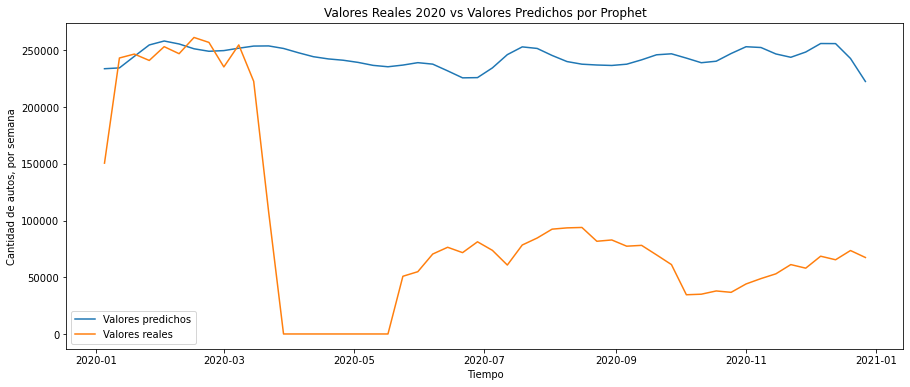

In [93]:
#Graficamos nuestros datos reales y predichos
plt.figure(figsize = (15,6))
plt.plot(final.Prophet, label = 'Valores predichos')
plt.plot(final.Reales,label = 'Valores reales')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Valores Reales 2020 vs Valores Predichos por Prophet')
plt.show()

Podemos observar que las predicciones que fueron realizadas por Prophet se muestran cerca de los valores reales durante los primeros tres meses. Sin embargo, los valores reales tienen una caída muy fuerte en el mes de marzo, llegnado casi a niveles de cero pases de automóviles de manera semanal y posterior a mayo vuelven a incrementar, pero lejos de los valores predichos. Debemos tomar en cuenta que en el año 2020 a partir de marzo, en muchos lugares del mundo, incluyendo Argentina, se vivieron confinamientos como medida de prevención ante la pandemia del COVID-19. 

Dicho evento no fue tomado en consideración por el modelo, y es por ello que apartir de marzo las predicciones son invalidadas por no tomar en cuenta dicho factor. 

## Conclusión

Luego de haber elaborado el notebook con los nuevos modelos, se conlcuye que el modelo Prophet presenta un mejor desempeño que el modelo ARIMA. El modelo logra una buena predicción dentro de los datos que se tienen, así como los primeros 3 meses del año 2020. 

Se deben mencionar las variables ajenas a los modelos que los hacen vulnerables frente a los datos presentados. En primer lugar, el modelo ARIMA como se explicó anteriormente, funciona de manera correcta con datos que no son estacionarios, caso que no es verdad para los datos que se manejan. También entra el juego el factor de la pandemia que se vivió en el año 2020, ya que es una variable muy fuerte para poder predecir los pases de automóviles en dicho año, que se puede considerar como atípico. 

Como medidas que se pueden implementar, sería el utilizar los datos sin filtración para la estación Illía. Es decir, no diferenciar en cuento a los métodos de pago, y tomar el total de pases de automóviles.  